# Este trabajo fue realizado por Luciano Tangorra, utilizando como guia el material brindado por la cátedra de Procesamiento de lenguaje natural mediante redes neuronales, de la ECI 2019, y conocimiento previo obtenido en su universidad (UNICEN).

Disculpen la desprolijidad del código y lo feo de la implementación, hice mi mejor esfuerzo.

Para poder utilizar este código lo único que deben hacer es modificar las variables que poseen direction en el nombre, es decir, las direcciones de donde se obtienen los datos. Estas variables se encuentran en el código que siga a cada sección llamada preprocesamiento.

Cualquier duda lucianotangorra@gmail.com

In [0]:
from google.colab import drive
import pandas as p

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Las siguientes dos funciones son para obtener linea a linea los datos de los archivos

In [0]:
def read_json(sentence_data):
    for line in sentence_data:
        #print(line)
        example = json.loads(line)
        yield example['sentence2'].split()

def read_cvs(tag_data, sentence_len=0):
    for index, row in tag_data.iterrows():
        yield row['gold_label'].split()

Proceso los datos.
Armo el vocabulario y le asigno un valor entero a cada indice. 
Guardo los indices de cada palabra de la sentencia como una nueva sentencia para luego utilizarla para crear los embeddings.

In [0]:
def processData(data, tags, word_to_ix):
    # Se encarga de procesar los datos y los tags, devolviendo un arreglo de sentencias
    # expresadas con indices (unicos por palabra) y un arreglo de tags expresados con
    # indices, asi como tambien la longitud maxima de sentencia
    
    # Params ------
    # data: un open de un archivo json que contenga lineas con datos
    # tag: un read_csv que contenga los tags que corresponden a cada linea de la data

    # Return ------
    # training_data: arreglo que contiene las sentencias expresadas con indices unicos por palabra
    # training_tags: arreglo que contiene los tags para cada sentencia, expresados con indices unicos por tag
    # max_len: maxima longitud de sentencia
    
    tag_to_ix = { 'entailment': 0,  'neutral': 1, 'contradiction': 2 }

    #word_to_ix = {} # Dicc de palabra a indice (sin contar el 0 ya que es para el padding)
    training_data = [] # Indices de las palabras pertenecientes a cada sentencia, por cada sentencia.
    training_tag = [] # Indices de los tags correspondientes a cada sentencia.
    cantidad_sentencias = 0 # Dato curioso nomas, no sirve para nada mas que para saber cuantas sentencias hay
    max_len = 0 # maxima cantidad de palabras en una sentencia. Es para que despues todas las otras sentencias 
                # se rellenen de 0s hasta el mismo tam.

    for sentence, tag in zip(read_json(data), read_cvs(tags)):
        # Tenemos la oración en sentence con su categoría en label
        cantidad_sentencias += 1
        posible_max_len = 0
        ix_sentence = []
        for word in sentence:
            if word[len(word)-1] == '.': # Le saco el '.' a la palabra
                word = word[:-1]
            posible_max_len += 1

            if word not in word_to_ix:    
                word_to_ix[word] = len(word_to_ix) + 1 # Tomo el 0 como discernible para el pad, por eso el +1

            ix_sentence.append(word_to_ix[word]) # Agrego a la sentencia (hecha con indices) el indice de la palabra

            if posible_max_len > max_len:
                max_len = posible_max_len # Si el tam de la sentencia es mayor al maximo actual, lo reemplazo

        training_data.append(ix_sentence)
        training_tag.append(tag_to_ix[tag[0]])
    vocab_size = len(word_to_ix)
    print('Vocabulary size: ', vocab_size)
    print(cantidad_sentencias)
    print(word_to_ix)
    print(tag_to_ix)
    return training_data, training_tag, max_len, vocab_size

#vocab_size = len(word_to_ix)
#print(cantidad_sentencias)
#print(word_to_ix)
#print(tag_to_ix)

# Preprocesamiento de los datos de train

In [0]:
#!/usr/bin/env python
import argparse
import json
import csv

word_to_ix = {}

data_direction = '/content/drive/My Drive/Estudios/Cursos/ECI/snli_1.0_train_filtered.jsonl'
tag_direction = '/content/drive/My Drive/Estudios/Cursos/ECI/snli_1.0_train_gold_labels.csv'

sentence_data = open(data_direction, 'r')
tag_data = p.read_csv(tag_direction)

In [0]:
training_data, training_tag, max_len, vocab_size = processData(sentence_data, tag_data, word_to_ix)

Vocabulary size:  40690
549367
{'A': 1, 'person': 2, 'is': 3, 'training': 4, 'his': 5, 'horse': 6, 'for': 7, 'a': 8, 'competition': 9, 'at': 10, 'diner,': 11, 'ordering': 12, 'an': 13, 'omelette': 14, 'outdoors,': 15, 'on': 16, 'They': 17, 'are': 18, 'smiling': 19, 'their': 20, 'parents': 21, 'There': 22, 'children': 23, 'present': 24, 'The': 25, 'kids': 26, 'frowning': 27, 'boy': 28, 'skates': 29, 'down': 30, 'the': 31, 'sidewalk': 32, 'does': 33, 'skateboarding': 34, 'trick': 35, 'wearing': 36, 'safety': 37, 'equipment': 38, 'An': 39, 'older': 40, 'man': 41, 'drinks': 42, 'juice': 43, 'as': 44, 'he': 45, 'waits': 46, 'daughter': 47, 'to': 48, 'get': 49, 'off': 50, 'work': 51, 'flips': 52, 'burger': 53, 'elderly': 54, 'sits': 55, 'in': 56, 'small': 57, 'shop': 58, 'Some': 59, 'women': 60, 'hugging': 61, 'vacation': 62, 'sleeping': 63, 'showing': 64, 'affection': 65, 'people': 66, 'eating': 67, 'omelettes': 68, 'sitting': 69, 'desks': 70, 'school': 71, 'diners': 72, 'restaurant': 73, '

Keras necesita que le pase el resultado de cada neurona de salida, con un 1 donde se encuentra la salida correcta y 0s en los demas lados, el to_categorical hace exactamente eso si le paso una lista de tags.

In [0]:
from keras.utils import to_categorical

training_tag = to_categorical(training_tag)

Agrego 0s al final de cada sentencia para que todas queden del mismo tamaño (Keras pide que sea asi)

In [0]:
from keras.preprocessing.sequence import pad_sequences

training_data = pad_sequences(training_data,maxlen=max_len,padding='post',value=0.0)

In [0]:
print(training_data.shape)
print(training_tag.shape)

(549367, 56)
(549367, 3)


# Preprocesamiento de los datos de dev

Lo mismo que con los datos de training. 
Se procesan los datos de las sentencias y los tags.
A los tags se los arma como una matriz con 0s excepto en el lugar que corresponda.
A las sentencias se las deja con 0s al final para que todas tengan la misma longitud.

In [0]:
dev_data_direction = '/content/drive/My Drive/Estudios/Cursos/ECI/snli_1.0_dev_filtered.jsonl'
dev_tag_direction = '/content/drive/My Drive/Estudios/Cursos/ECI/snli_1.0_dev_gold_labels.csv'
sentence_dev_data = open(dev_data_direction, 'r')
tag_dev_data = p.read_csv(dev_tag_direction)

In [0]:
dev_data, dev_tag, dev_max_len, _ = processData(sentence_dev_data, tag_dev_data, word_to_ix)

Vocabulary size:  41010
9842
{'A': 1, 'person': 2, 'is': 3, 'training': 4, 'his': 5, 'horse': 6, 'for': 7, 'a': 8, 'competition': 9, 'at': 10, 'diner,': 11, 'ordering': 12, 'an': 13, 'omelette': 14, 'outdoors,': 15, 'on': 16, 'They': 17, 'are': 18, 'smiling': 19, 'their': 20, 'parents': 21, 'There': 22, 'children': 23, 'present': 24, 'The': 25, 'kids': 26, 'frowning': 27, 'boy': 28, 'skates': 29, 'down': 30, 'the': 31, 'sidewalk': 32, 'does': 33, 'skateboarding': 34, 'trick': 35, 'wearing': 36, 'safety': 37, 'equipment': 38, 'An': 39, 'older': 40, 'man': 41, 'drinks': 42, 'juice': 43, 'as': 44, 'he': 45, 'waits': 46, 'daughter': 47, 'to': 48, 'get': 49, 'off': 50, 'work': 51, 'flips': 52, 'burger': 53, 'elderly': 54, 'sits': 55, 'in': 56, 'small': 57, 'shop': 58, 'Some': 59, 'women': 60, 'hugging': 61, 'vacation': 62, 'sleeping': 63, 'showing': 64, 'affection': 65, 'people': 66, 'eating': 67, 'omelettes': 68, 'sitting': 69, 'desks': 70, 'school': 71, 'diners': 72, 'restaurant': 73, 'dr

In [0]:
dev_tag = to_categorical(dev_tag)

In [0]:
dev_data = pad_sequences(dev_data,maxlen=dev_max_len,padding='post',value=0.0)

#Ahora arranco con la red neuronal.


Input: tiene de output None, es decir, puede tener tamaño variable el input por cada batch (aunque hice el padding para que todas las sentencias tengan el mismo tam, de otro modo tendria que haber hecho bucketing para que se agrupen todas las sentencias de la misma longitud para cada batch).


Embedding: - input_dim es el tam del vocabulario (+1 porque tomo el 0 por el padding), serian las filas de la matriz de embeddings. 
                      - output_dim es el tam del embedding (cuantas relaciones semanticas va a tener para aprender sobre la palabra).
                      - input_length es la cantidad de palabras que tiene cada sentencia. Es none ya que puede tener tamaño de sentencia variada, aunque hice que todas las sentencias tengan la misma longitud pero POR conjunto de datos, es decir que las sentencias de entrenamiento y las de test pueden tener tamaño diferentes.
                      - mask_zero es para que ignore a los 0s, ya que los añadí por el padding.


LSTM: - posee 100 neuronas de salida por palabra. 
            - Return_sequences me devuelve la salida de cada palabra si es true o solo la de la última (seria como de la sentencia completa) si es false (en este caso quiero la ultima para ver dada toda la sentencia que tag le corresponde). 
            - Si bien la capa LSTM posee activacion tanh por defecto la escribi para mayor legibilidad. 
            - recurrent_dropout hace un dropout entre el output y hidden de cada palabra conectado a la siguiente.
            - dropout hace un dropout hace un dropout de la salida, "inhabilitando" algunas neuronas del último output.

Dense: capa oculta densa de 100 neuronas, utilizando la funcion de activacion relu.

Dense: capa densa de salida de la red, tiene 3 salidas ya que son los posibles tags, es una softmax para normalizar la salida.

Se utilizo nadam, que seria adam con Nesterov momentum y se mantuvieron los parametros por defecto, el cual implementa un lr inicial de 0.002.

In [0]:
from keras.layers import Embedding, Dense, LSTM, Input, Dropout
from keras.models import Model
from keras.optimizers import RMSprop


i = Input(shape=(None,))  
d = Embedding(input_dim=vocab_size + 1,output_dim=128, mask_zero=True)(i)
d = LSTM(128, activation='tanh', return_sequences=False, recurrent_dropout=0.4, dropout=0.4)(d)
d = Dense(100, activation='relu')(d)
d = Dense(3, activation='softmax')(d)


#optimizer = RMSprop(lr=0.01)

model = Model(inputs=i, outputs=d)
model.summary()
#Con adam no anduvo muy bien, con RMSprop tampoco
#model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['categorical_accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, None)              0         
_________________________________________________________________
embedding_25 (Embedding)     (None, None, 128)         5208448   
_________________________________________________________________
lstm_34 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_34 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 303       
Total params: 5,353,235
Trainable params: 5,353,235
Non-trainable params: 0
_________________________________________________________________


Entreno la red y veo la acc del dev por cada epoch.

In [0]:
h = model.fit(training_data, training_tag, epochs=3, batch_size=512, validation_data=(dev_data, dev_tag))

Train on 549367 samples, validate on 9842 samples
Epoch 1/3
549367/549367 [==============================] - 213s 388us/step - loss: 0.8275 - categorical_accuracy: 0.6286 - val_loss: 0.7731 - val_categorical_accuracy: 0.6636
Epoch 2/3
549367/549367 [==============================] - 203s 369us/step - loss: 0.7559 - categorical_accuracy: 0.6693 - val_loss: 0.7603 - val_categorical_accuracy: 0.6711
Epoch 3/3
549367/549367 [==============================] - 202s 367us/step - loss: 0.7221 - categorical_accuracy: 0.6862 - val_loss: 0.7696 - val_categorical_accuracy: 0.6752


Ploteo los datos para que sea mas facil de observar la perdida y la acc.

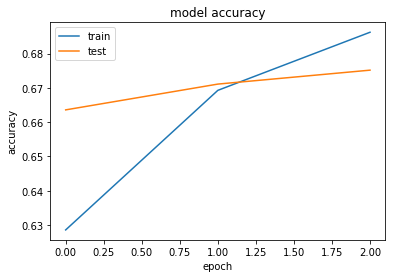

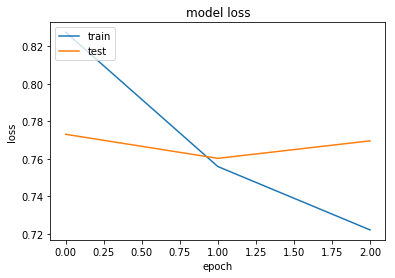

In [0]:
%matplotlib inline
import pickle
import numpy as np
from matplotlib import pyplot as plt

plt.plot(h.history['categorical_accuracy'])
plt.plot(h.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Ahora con los datos de test!
# Preprocesamiento datos test 


In [0]:
test_data_direction = '/content/drive/My Drive/Estudios/Cursos/ECI/snli_1.0_test_filtered.jsonl'

sentence_test_data = open(test_data_direction, 'r')

#Dev_tag es solo para que funcione
tag_dev_data = p.read_csv(dev_tag_direction)
test_data, _, test_max_len, _ = processData(sentence_test_data, tag_dev_data, word_to_ix)

test_data = pad_sequences(test_data,maxlen=test_max_len,padding='post',value=0.0)

Vocabulary size:  41345
9824
{'A': 1, 'person': 2, 'is': 3, 'training': 4, 'his': 5, 'horse': 6, 'for': 7, 'a': 8, 'competition': 9, 'at': 10, 'diner,': 11, 'ordering': 12, 'an': 13, 'omelette': 14, 'outdoors,': 15, 'on': 16, 'They': 17, 'are': 18, 'smiling': 19, 'their': 20, 'parents': 21, 'There': 22, 'children': 23, 'present': 24, 'The': 25, 'kids': 26, 'frowning': 27, 'boy': 28, 'skates': 29, 'down': 30, 'the': 31, 'sidewalk': 32, 'does': 33, 'skateboarding': 34, 'trick': 35, 'wearing': 36, 'safety': 37, 'equipment': 38, 'An': 39, 'older': 40, 'man': 41, 'drinks': 42, 'juice': 43, 'as': 44, 'he': 45, 'waits': 46, 'daughter': 47, 'to': 48, 'get': 49, 'off': 50, 'work': 51, 'flips': 52, 'burger': 53, 'elderly': 54, 'sits': 55, 'in': 56, 'small': 57, 'shop': 58, 'Some': 59, 'women': 60, 'hugging': 61, 'vacation': 62, 'sleeping': 63, 'showing': 64, 'affection': 65, 'people': 66, 'eating': 67, 'omelettes': 68, 'sitting': 69, 'desks': 70, 'school': 71, 'diners': 72, 'restaurant': 73, 'dr

Predigo los resultados y los convierto a una salida legible (Neutral, entailment, contradiction)

In [0]:
predictions = model.predict(test_data)

In [0]:
type(predictions)

numpy.ndarray

In [0]:
predictions.shape

(9824, 3)

In [0]:
predictions

array([[0.1024257 , 0.5242488 , 0.3733255 ],
       [0.10477603, 0.6812012 , 0.21402276],
       [0.14841472, 0.31853777, 0.53304756],
       ...,
       [0.10125417, 0.0482024 , 0.85054344],
       [0.48555356, 0.18169637, 0.33274996],
       [0.18309972, 0.32193324, 0.494967  ]], dtype=float32)

In [0]:
ix_to_tag = { 0: 'entailment',  1: 'neutral', 2: 'contradiction' }
tags = np.argmax(predictions, axis=1)
tags

array([1, 1, 2, ..., 2, 0, 2])

In [0]:
results = []
for prediction in tags:
    results.append(ix_to_tag[prediction])
results

['neutral',
 'neutral',
 'contradiction',
 'entailment',
 'neutral',
 'entailment',
 'entailment',
 'neutral',
 'entailment',
 'neutral',
 'entailment',
 'neutral',
 'neutral',
 'entailment',
 'contradiction',
 'contradiction',
 'entailment',
 'neutral',
 'contradiction',
 'contradiction',
 'contradiction',
 'contradiction',
 'entailment',
 'neutral',
 'neutral',
 'contradiction',
 'entailment',
 'entailment',
 'neutral',
 'contradiction',
 'contradiction',
 'entailment',
 'entailment',
 'contradiction',
 'contradiction',
 'contradiction',
 'contradiction',
 'entailment',
 'contradiction',
 'entailment',
 'entailment',
 'contradiction',
 'contradiction',
 'contradiction',
 'contradiction',
 'neutral',
 'entailment',
 'entailment',
 'neutral',
 'neutral',
 'neutral',
 'entailment',
 'contradiction',
 'contradiction',
 'neutral',
 'entailment',
 'entailment',
 'contradiction',
 'neutral',
 'entailment',
 'contradiction',
 'neutral',
 'neutral',
 'entailment',
 'neutral',
 'entailment',
 

In [0]:
import argparse
import json
import csv

def guardar(test_tags):
    "Junta el archivo con las oraciones de test (jsonl)"
    " y los resultados de la clasificación de tu algoritmo (en tu formato)"
    " en un archivo csv compatible con el formato de Kaggle"

    sentences_filename = '/content/drive/My Drive/Estudios/Cursos/ECI/snli_1.0_test_filtered.jsonl'
    #labels_filename = "test_cls.txt"
    output_filename = "result.csv"

    with open(output_filename, 'w') as fout:
        csv_writer = csv.writer(fout)
        csv_writer.writerow(['pairID', 'gold_label'])

        for pairID, label in it_ID_label_pairs(sentences_filename, test_tags):
            #formatted_label = format_label(label)
            #print(formatted_label)
            
            csv_writer.writerow([pairID, label])

def format_label(label):
    return label[len("__label__"):]

def it_ID_label_pairs(sentences_filename, test_tags):
    sentence_data = open(sentences_filename, 'r')
    #labels_data = open(labels_filename, 'r')
    for pairID, label in zip(it_ID(sentence_data), test_tags):
        yield pairID, label

def it_ID(sentence_data):
    for line in sentence_data:
        example = json.loads(line)
        yield example['pairID']

def it_labels(label_data):
    for label in label_data:
        label = label.rstrip('\n')  # sacamos el fin de linea
        yield label
        
guardar(results)